### YKA Rathnasiri - 27413
# **Job Matching Engine – Data Exploration & Model Development**

## Project Overview

This notebook implements an intelligent job recommendation system that matches candidate CVs with IT job postings in Sri Lanka using semantic similarity and skills matching.

---

## Dataset

**Source:** LinkedIn IT Related Job Postings (Sri Lanka)  
**Collection Method:** Web scraping  
**Size:** ~1,500+ jobs  

---


## Models Used

This is an **unsupervised learning** approach

**1. SBERT (Sentence-BERT)**
- Pre-trained transformer model
- Converts text to 384-dimensional semantic vectors
- Captures meaning beyond keywords

**2. PCA (Principal Component Analysis)**
- Reduces 384 to 128 dimensions
- Preserves >80% variance
- Faster search + reduced storage

**3. FAISS (Fast Similarity Search)**
- HNSW index for nearest neighbor search
- Sub-millisecond retrieval
- Scalable to millions of jobs

---

## System Pipeline

```
CV PDF → Text Extraction → Skill Extraction
    ↓
Clean Text → SBERT Encode (384-dim)
    ↓
PCA Transform (128-dim)
    ↓
FAISS Search → Top-K Jobs
    ↓
Job Recommendations
```

---

### Why This Approach Works

- No labeled data needed
- Semantic understanding (not just keywords)
- Fast real-time search
- Explainable results
- Scalable to large databases

---

**Semantic Similarity:** Understands context and meaning  
**Skill Match:** Ensures technical requirements are met

---


## 1. Data Loading and Initial Inspection

In [68]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load dataset
file_path = 'linkedin_sri_lanka_IT_jobs.csv'
df = pd.read_csv(file_path)

# Display random samples
display(df.sample(n=10, random_state=42))

,job_id,title,company,location,posted_date,job_url,search_keyword,scraped_at,description,required_skills,experience_level,employment_type,job_function,industries,job_criteria,num_applicants
51,4085645634,Senior Software Engineer - .Net + Angular,"Riskonnect, Inc.","Colombo, Western Province, Sri Lanka",2025-10-11,https://lk.linkedin.com/jobs/view/senior-softw...,software developer,2025-10-14 10:04:29,Responsibilities Participate in requirements a...,".Net, Asp.Net, Sql, Scss, Css, Scrum, Javascri...",Mid-Senior level,Full-time,Engineering and Information Technology,Software Development,Seniority level: Mid-Senior level | Employment...,Over 200 applicants
168,4298715494,JUNIOR IOS DEVELOPER,Ontash,"Colombo, Western Province, Sri Lanka",2025-09-10,https://lk.linkedin.com/jobs/view/junior-ios-d...,software engineer,2025-10-14 10:10:02,We are hiring Freshers for the post of Junior ...,"Java, Objective-C, Sql, Xcode, C, Python, Ios,...",Entry level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,Seniority level: Entry level | Employment type...,93 applicants
1469,4302341717,Senior Associate - Fund Control Specialist - L...,Acuity Knowledge Partners,"Colombo, Western Province, Sri Lanka",2025-10-14,https://lk.linkedin.com/jobs/view/senior-assoc...,consultant,2025-10-14 15:46:12,We are seeking a detail-oriented and organised...,NaN,Mid-Senior level,Full-time,Other,Financial Services,Seniority level: Mid-Senior level | Employment...,50 applicants
926,4312803994,Intern - Managed Security Services,MillenniumIT ESP,"Colombo, Western Province, Sri Lanka",2025-10-10,https://lk.linkedin.com/jobs/view/intern-manag...,cybersecurity engineer,2025-10-14 13:38:22,Job Description Security Monitoring Continuous...,"Siem, Ids, Security, Ips",Not Applicable,Internship,"Other, Information Technology, and Management",IT Services and IT Consulting,Seniority level: Not Applicable | Employment t...,167 applicants
422,4288225489,WordPress Developer & AI Digital Marketing Sp...,Jolera,"Colombo, Western Province, Sri Lanka",2025-08-20,https://lk.linkedin.com/jobs/view/wordpress-de...,php developer,2025-10-14 10:40:15,Who We Are: Jolera stands as a distinguished m...,"Ux, Wordpress, Ui, User Experience, Security, ...",Entry level,Full-time,Marketing,IT Services and IT Consulting,Seniority level: Entry level | Employment type...,89 applicants
1090,4294535117,Marketing Content Manager,TransMedia Inc.,"Colombo, Western Province, Sri Lanka",2025-09-04,https://lk.linkedin.com/jobs/view/marketing-co...,product manager,2025-10-14 14:23:15,Position: Marketing Content Manager (SEO & Gro...,"Ai, Seo, Agile",Mid-Senior level,Full-time,Marketing and Sales,Software Development,Seniority level: Mid-Senior level | Employment...,152 applicants
585,4306196459,Senior Architect,Virtusa,"Colombo, Western Province, Sri Lanka",2025-10-01,https://lk.linkedin.com/jobs/view/senior-archi...,team lead,2025-10-14 11:18:50,Key Responsibilities Technology Operations Str...,"Aws, Gcp, Ansible, Soc 2, Devops, Splunk, Rpa,...",Mid-Senior level,Full-time,"Design, Art/Creative, and Information Technology",IT Services and IT Consulting,Seniority level: Mid-Senior level | Employment...,Be among the first 25 applicants
220,4300717800,Quality Assurance Test Lead,HCLTech Sri Lanka,"Colombo District, Western Province, Sri Lanka",2025-10-13,https://lk.linkedin.com/jobs/view/quality-assu...,software engineer,2025-10-14 10:13:34,"About HCLTech Sri Lanka At HCLTech Sri Lanka, ...","Agile, Testing",Mid-Senior level,Full-time,Quality Assurance and Information Technology,IT Services and IT Consulting,Seniority level: Mid-Senior level | Employment...,155 applicants
1468,4300913878,Customer Success Analyst (IGT1 Lanka - Rhapsody),IFS,"Colombo, Western Province, Sri Lanka",2025-09-15,https://lk.linkedin.com/jobs/view/customer-suc...,consultant,2025-10-14 15:45:32,IGT1 Lanka is a rapidly growing offshore techn...,"Pardot, Batch Processing, Problem Solving, Sal...",Executive,Full

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_id            1516 non-null   int64 
 1   title             1516 non-null   object
 2   company           1516 non-null   object
 3   location          1516 non-null   object
 4   posted_date       1516 non-null   object
 5   job_url           1516 non-null   object
 6   search_keyword    1516 non-null   object
 7   scraped_at        1516 non-null   object
 8   description       1516 non-null   object
 9   required_skills   1309 non-null   object
 10  experience_level  1516 non-null   object
 11  employment_type   1516 non-null   object
 12  job_function      1502 non-null   object
 13  industries        1513 non-null   object
 14  job_criteria      1516 non-null   object
 15  num_applicants    1516 non-null   object
dtypes: int64(1), object(15)
memory usage: 189.6+ KB


## 2. Data Quality Assessment

In [31]:
# Create column audit report
column_audit = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes.values,
    'Non-Null Count': df.count().values,
    'Null Count': df.isnull().sum().values,
    'Null %': (df.isnull().sum() / len(df) * 100).round(2).values,
    'Unique Values': [df[col].nunique() for col in df.columns]
})

print("Column Audit Report:")
print(column_audit.to_string(index=False))

# Identify crucial columns for modeling
crucial_cols = ['title', 'description', 'required_skills', 'company', 'location',
                'posted_date', 'experience_level', 'employment_type']

print("\nCrucial Columns for Modeling:")
crucial_audit = column_audit[column_audit['Column'].isin(crucial_cols)]
print(crucial_audit.to_string(index=False))

# Check missing values
missing_info = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_%': (df.isnull().sum() / len(df) * 100).round(2)
})

display(missing_info[missing_info['Missing_Count'] > 0])

# Flag risky columns (>30% missing)
risky_cols = column_audit[column_audit['Null %'] > 30]
if len(risky_cols) > 0:
    print("\nWARNING: Risky Columns (>30% Missing):")
    print(risky_cols[['Column', 'Null %']].to_string(index=False))
    print("\nFallback Strategy: Ignore these columns or use 'Unknown' placeholder where necessary.")

Column Audit Report:
          Column Data Type  Non-Null Count  Null Count  Null %  Unique Values
          job_id     int64            1516           0    0.00           1516
           title    object            1516           0    0.00           1313
         company    object            1516           0    0.00            477
        location    object            1516           0    0.00             80
     posted_date    object            1516           0    0.00            133
         job_url    object            1516           0    0.00           1516
  search_keyword    object            1516           0    0.00            106
      scraped_at    object            1516           0    0.00           1516
     description    object            1516           0    0.00           1468
 required_skills    object            1309         207   13.65            983
experience_level    object            1516           0    0.00              7
 employment_type    object            1516 

,Column,Missing_Count,Missing_%
required_skills,required_skills,207,13.65
job_function,job_function,14,0.92
industries,industries,3,0.20


## 3. Data Preprocessing and Cleaning

In [66]:
# Handle missing values in critical columns
# Fill missing values in critical text columns
df['title'] = df['title'].fillna('Unknown Position')
df['description'] = df['description'].fillna('')
df['required_skills'] = df['required_skills'].fillna('')
df['company'] = df['company'].fillna('Unknown Company')
df['location'] = df['location'].fillna('Unknown Location')

# Fill missing values in categorical columns
if 'experience_level' in df.columns:
    df['experience_level'] = df['experience_level'].fillna('Not Specified')
if 'employment_type' in df.columns:
    df['employment_type'] = df['employment_type'].fillna('Not Specified')

# Remove rows where both description and skills are empty (unusable for matching)
df = df[~((df['description'] == '') & (df['required_skills'] == ''))]

# Reset index after dropping rows
df = df.reset_index(drop=True)

print("\nMissing values in critical columns after preprocessing:")
print(df[['title', 'description', 'required_skills', 'company', 'location']].isnull().sum())


Missing values in critical columns after preprocessing:
title              0
description        0
required_skills    0
company            0
location           0
dtype: int64


## 4. Exploratory Data Analysis (EDA)

### A. Overall Job Market Size & Demand Hotspots

I. Provides a fundamental measure of the current job market scale within the dataset.


In [34]:
total_job_postings = len(df)
print(f"\nOverall IT Job Postings - Present Market Size: {total_job_postings}")


Overall IT Job Postings - Present Market Size: 1516


II. Job Posting Date Range

In [35]:
df['posted_date'] = pd.to_datetime(df['posted_date'])
print("\nDate Range:", df['posted_date'].min(), "to", df['posted_date'].max())


Date Range: 2023-07-02 00:00:00 to 2025-10-14 00:00:00


III. Postings by Year

In [36]:
print("\nPostings by Year:")
print(df['posted_date'].dt.year.value_counts())


Postings by Year:
posted_date
2025    1507
2023       5
2024       4
Name: count, dtype: int64


IV. Top Industries by IT Job Postings - Demand Hotspots

Pinpoints industries with the highest IT job demand, crucial for industry focus and job seeker targeting.

In [37]:
industry_counts = df['industries'].value_counts().head(10)
print(f"\nTop Industries by IT Job Postings - Demand Hotspots:\n\n{industry_counts}")


Top Industries by IT Job Postings - Demand Hotspots:

industries
IT Services and IT Consulting                           431
Software Development                                    129
IT Services and IT Consulting and Financial Services     74
Business Consulting and Services                         62
Financial Services                                       42
Telecommunications                                       40
Hospitals and Health Care                                39
Transportation, Logistics, Supply Chain and Storage      37
Technology, Information and Internet                     37
Information Technology & Services                        34
Name: count, dtype: int64


### B. Experience Level and Employment Type Demand

I. Experience Level Demand Distribution - Targeting Guidance
Guides job seekers in targeting appropriate roles and students in aligning career paths with market experience demand.

In [38]:
import plotly.express as px

experience_counts = df['experience_level'].value_counts()
experience_percentage = df['experience_level'].value_counts(normalize=True) * 100
print(f"\nExperience Level Demand Distribution - Targeting Guidance:\n\n{experience_counts}")

# Create the second chart: Experience Level Distribution
fig_experience = px.pie(df, names="experience_level", title="Experience Level Distribution",
                       color_discrete_sequence=px.colors.sequential.RdBu) # Use a red-blue color scheme
fig_experience.show()


Experience Level Demand Distribution - Targeting Guidance:

experience_level
Mid-Senior level    752
Entry level         325
Not Applicable      173
Associate           135
Internship           56
Executive            51
Director             24
Name: count, dtype: int64


II. Highlights employer preferences for employment types, indicating market trends towards permanent or flexible work.

In [39]:
# Employment Type Preference
employment_counts = df['employment_type'].value_counts()
employment_percentage = df['employment_type'].value_counts(normalize=True) * 100
print(f"\n Employment Type Preference :\n{employment_counts}")


 Employment Type Preference :
employment_type
Full-time     1349
Contract        88
Internship      34
Part-time       23
Other           14
Temporary        8
Name: count, dtype: int64


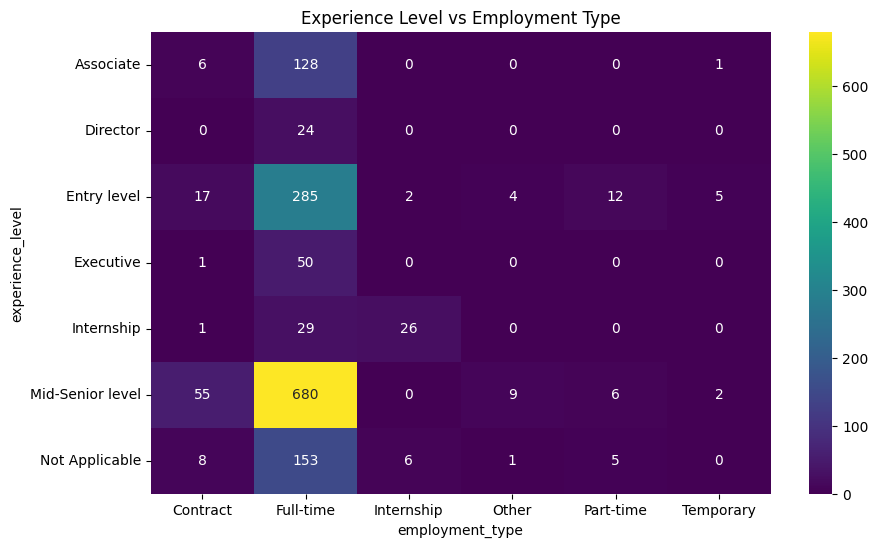

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Experience Level by Employment Type
pd.crosstab(df['experience_level'], df['employment_type'])

plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(df['experience_level'], df['employment_type']), annot=True, fmt='d', cmap='viridis')
plt.title('Experience Level vs Employment Type')
plt.show()

### C. Top Roles, Companies, and Job Functions

I. Directly guides job seekers and students to the most sought-after job roles in the market.

In [41]:
# Count job categories
job_category_counts = df['title'].value_counts().reset_index()
job_category_counts.columns = ['Job Category', 'Count']

# Horizontal bar chart with different pastel colors
fig = px.bar(
    job_category_counts.head(15), # Limit to top 15 for better visualization
    x='Count',
    y='Job Category',
    orientation='h',
    color='Job Category',  # assign different color per category
    color_discrete_sequence=px.colors.qualitative.Pastel,  # pastel color palette
    text='Count',
    title='Number of Job Postings per Title (Top 15)',
)

fig.update_traces(textposition='outside', showlegend=False)  # hide legend
fig.update_layout(yaxis=dict(categoryorder='total ascending'))  # optional: sort by count
fig.show()

II. Identifies major hiring companies, crucial for job seeker targeting and competitive analysis within industries.

In [42]:
# Get top 10 hiring companies
top_companies = df['company'].value_counts().head(10).reset_index()
top_companies.columns = ['Company', 'Count']

# Create horizontal bar chart
fig = px.bar(
    top_companies,
    x='Count',
    y='Company',
    orientation='h',
    color='Company',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    text='Count',
    title='Top Hiring Companies - Key Employers & Competitive Landscape'
)

fig.update_traces(textposition='outside', showlegend=False)
fig.update_layout(
    yaxis=dict(categoryorder='total ascending'),
    width=1000,
    height=600
)

fig.show()

III. Company-Level Hiring Trends: For the top hiring companies, analyze their job posting patterns over time, the types of roles they are frequently hiring for, and the skills they emphasize.

In [43]:
# Company-Level Hiring Trends Analysis
def analyze_company_hiring(company, top_n=10):
    """Analyzes hiring trends for a specific company."""
    company_df = df[df['company'] == company]

    if company_df.empty:
        print(f"No data found for company: {company}")
        return

    # Analyze top job titles
    top_job_titles = company_df['title'].value_counts().head(top_n)
    print(f"\nTop {top_n} Job Titles at {company}:\n{top_job_titles}")

# Analyze top 5 companies
top_companies = df['company'].value_counts().head(5).index
for company in top_companies:
    print(f"\nCompany Hiring Trend Analysis for: {company}")
    analyze_company_hiring(company)



Company Hiring Trend Analysis for: Virtusa

Top 10 Job Titles at Virtusa:
title
Customer Support Agent                   5
Senior Software Engineer .Net + React    3
Lead DevOps Engineer                     3
Lead Data Engineer - Azure               3
Data Architect                           3
Lead Python Developer                    3
C# .Net Engineer                         2
Platform Ops Engineer                    2
C#.Net Lead                              2
Lead Data Engineer                       2
Name: count, dtype: int64

Company Hiring Trend Analysis for: LSEG

Top 10 Job Titles at LSEG:
title
Control Testing Specialist                            6
Senior Security Engineer                              3
Senior Executive, Accounts Receivables                2
Senior Engineer, Site Reliability Engineering         2
Senior Executive, Financial Accounting and Control    2
SDET                                                  2
Associate Lead DevOps Engineer                      

IV. Word Cloud for Job Titles

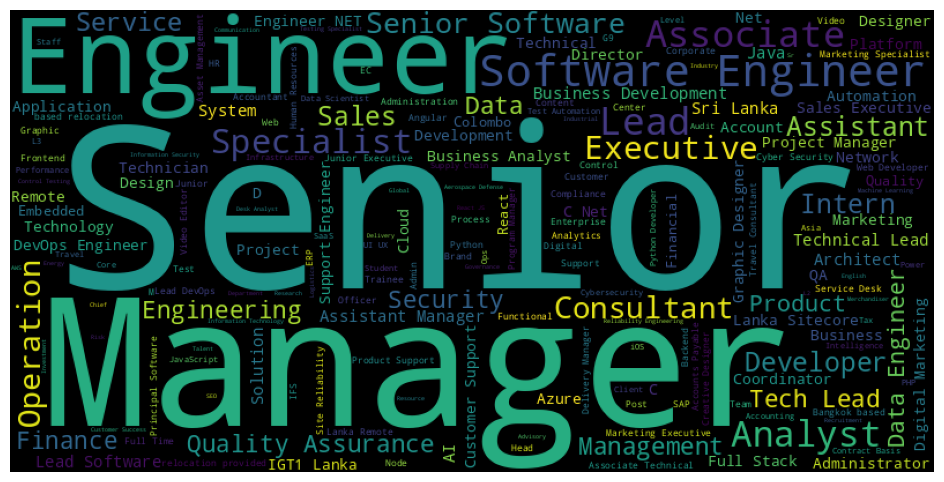

In [44]:
# Word Cloud for Job Titles
from wordcloud import WordCloud
import matplotlib.pyplot as plt

titles_text = ' '.join(df['title'].dropna())
wordcloud = WordCloud(width=800, height=400).generate(titles_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 5. Job Description Content & Text Analysis


In [45]:
#Import packages for text analysis
import nltk
import shutil
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
from nltk.util import ngrams
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


I. Identifies core skills and requirements, crucial for job seeker skill development and educational curriculum design.

In [46]:
# Top Single Word Keywords - Core Skill & Requirement Themes

def extract_keywords_unigram(text, n=20):
    if not isinstance(text, str):
        return Counter()
    words = re.findall(r'\b\w+\b', text.lower())
    nltk.download('stopwords') # download stopwords if not already downloaded
    stop_words_nltk = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if word not in stop_words_nltk and len(word) > 2]
    return Counter(words)

all_descriptions_text = ' '.join(df['description'].dropna())
unigram_keywords_counter = extract_keywords_unigram(all_descriptions_text, n=20)
top_unigram_keywords = unigram_keywords_counter.most_common(20)
print(f"\nTop Single Word Keywords - Core Skill Themes:\n{top_unigram_keywords}")

# Top Unigram Keywords
top_unigram_df = pd.DataFrame(top_unigram_keywords, columns=['Keyword', 'Frequency'])

fig_unigram_bar_adv = px.bar(top_unigram_df, x='Keyword', y='Frequency',
                     title='Top 20 Single Word Keywords - Core Skill Themes',
                     labels={'Frequency': 'Keyword Frequency', 'Keyword': 'Keyword'},
                     hover_data=['Frequency', 'Keyword'])
fig_unigram_bar_adv.show()


Top Single Word Keywords - Core Skill Themes:
[('experience', 4941), ('team', 3162), ('work', 3124), ('skills', 2912), ('data', 2393), ('business', 2234), ('support', 2183), ('management', 2140), ('strong', 2127), ('role', 2014), ('development', 1926), ('software', 1724), ('ensure', 1689), ('solutions', 1642), ('teams', 1613), ('design', 1598), ('knowledge', 1566), ('technical', 1557), ('ability', 1521), ('across', 1342)]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


II. Uncovers key two-word phrases indicating specific skill sets and role descriptions, offering nuanced job market insights.

In [47]:
# Top Bigram Keywords - Key Skill Phrases & Role Descriptors
def extract_keywords_bigram(text, n=20):
    if not isinstance(text, str):
        return Counter()
    tokens = nltk.word_tokenize(text.lower())
    stop_words_nltk = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words_nltk and word.isalpha()]
    bigrams_list = list(ngrams(tokens, 2))
    bigrams_filtered = [bigram for bigram in bigrams_list if len(' '.join(bigram)) > 4]
    return Counter(bigrams_filtered)

bigram_keywords_counter = extract_keywords_bigram(all_descriptions_text, n=20)
top_bigram_keywords = bigram_keywords_counter.most_common(20)
print(f"\nTop Bigram Keywords - Key Skill Phrases & Role Descriptors:\n{top_bigram_keywords}")

# Top Bigram Keywords
top_bigram_df = pd.DataFrame(top_bigram_keywords, columns=['Bigram', 'Frequency'])
top_bigram_df['Bigram'] = top_bigram_df['Bigram'].astype(str)

fig_bigram_bar_adv = px.bar(top_bigram_df, x='Bigram', y='Frequency',
                     title='Top 20 Bigram Keywords - Key Skill Phrases & Role Descriptors',
                     labels={'Frequency': 'Phrase Frequency', 'Bigram': 'Two-Word Phrase'},
                     hover_data=['Frequency', 'Bigram'])
fig_bigram_bar_adv.show()


Top Bigram Keywords - Key Skill Phrases & Role Descriptors:
[(('sri', 'lanka'), 645), (('years', 'experience'), 630), (('communication', 'skills'), 535), (('key', 'responsibilities'), 438), (('related', 'field'), 434), (('best', 'practices'), 431), (('bachelor', 'degree'), 423), (('skills', 'ability'), 391), (('ability', 'work'), 350), (('computer', 'science'), 320), (('excellent', 'communication'), 308), (('minimum', 'years'), 284), (('attention', 'detail'), 262), (('continuous', 'improvement'), 259), (('team', 'members'), 257), (('experience', 'working'), 250), (('job', 'description'), 249), (('join', 'us'), 236), (('software', 'development'), 227), (('work', 'closely'), 218)]


III. Reveals common three-word phrases that often represent specific job requirements, qualifications, or contextual role descriptions, providing highly specific job market signals.

In [48]:
# Top Trigram Keywords - Specific Role Requirements & Context
def extract_keywords_trigram(text, n=20):
    if not isinstance(text, str):
        return Counter()
    tokens = nltk.word_tokenize(text.lower())
    stop_words_nltk = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words_nltk and word.isalpha()]
    trigrams_list = list(ngrams(tokens, 3))
    trigrams_filtered = [trigram for trigram in trigrams_list if len(' '.join(trigram)) > 6]
    return Counter(trigrams_filtered)

trigram_keywords_counter = extract_keywords_trigram(all_descriptions_text, n=20)
top_trigram_keywords = trigram_keywords_counter.most_common(20)
print(f"\nTop Trigram Keywords - Role Requirements & Context:\n{top_trigram_keywords}")

# Top Trigram Keywords
top_trigram_df = pd.DataFrame(top_trigram_keywords, columns=['Trigram', 'Frequency'])
top_trigram_df['Trigram'] = top_trigram_df['Trigram'].astype(str)

fig_trigram_bar_adv = px.bar(top_trigram_df, x='Trigram', y='Frequency',
                     title='Top 20 Trigram Keywords - Role Requirements & Context',
                     labels={'Frequency': 'Phrase Frequency', 'Trigram': 'Three-Word Phrase'},
                     hover_data=['Frequency', 'Trigram'])
fig_trigram_bar_adv.show()


Top Trigram Keywords - Role Requirements & Context:
[(('degree', 'computer', 'science'), 177), (('minimum', 'years', 'experience'), 176), (('bachelor', 'degree', 'computer'), 129), (('sexual', 'orientation', 'gender'), 121), (('orientation', 'gender', 'identity'), 121), (('skills', 'ability', 'work'), 116), (('change', 'status', 'quo'), 112), (('ability', 'work', 'independently'), 108), (('strong', 'analytical', 'skills'), 106), (('related', 'field', 'years'), 105), (('london', 'stock', 'exchange'), 105), (('proven', 'track', 'record'), 103), (('excellent', 'communication', 'skills'), 100), (('communication', 'skills', 'ability'), 99), (('stock', 'exchange', 'group'), 97), (('engineering', 'related', 'field'), 93), (('people', 'across', 'countries'), 91), (('global', 'financial', 'markets'), 90), (('written', 'communication', 'skills'), 89), (('financial', 'markets', 'infrastructure'), 88)]


IV. Benchmarks benefit offerings, helping companies refine packages and job seekers evaluate compensation.

In [49]:
# Prepare the data (already done before this block)
requirement_keywords_categories = {
    'Educational Requirements': ['degree', 'bachelor', 'master', 'phd', 'diploma', 'certification', 'graduate', 'undergraduate', 'qualifications'],
    'Technical Skills': ['python', 'java', 'sql', 'cloud', 'aws', 'azure', 'gcp', 'javascript', 'react', 'angular', 'node.js', '.net', 'c#', 'c++', 'data analysis', 'machine learning', 'cybersecurity', 'networking'],
    'Soft Skills': ['communication skills', 'leadership skills', 'problem-solving', 'teamwork', 'collaboration', 'time management', 'customer service', 'interpersonal skills', 'presentation skills', 'negotiation skills'],
    'Experience Level Required': ['years of experience', 'relevant experience', 'minimum experience', 'proven experience', 'experience in', 'prior experience']
}

requirement_category_counts = {category: 0 for category in requirement_keywords_categories}
for category, keywords in requirement_keywords_categories.items():
    pattern = '|'.join(keywords)
    requirement_category_counts[category] = df['description'].str.contains(pattern, case=False, na=False).sum()

# Sort results
sorted_categories = dict(sorted(requirement_category_counts.items(), key=lambda item: item[1], reverse=True))

# Convert to DataFrame for better control
category_df = pd.DataFrame(sorted_categories.items(), columns=['Category', 'Count'])

# Plot horizontal bar chart
fig = px.bar(
    category_df,
    x='Count',
    y='Category',
    orientation='h',
    color='Category',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    text='Count',
    title='Requirement Keyword Category Analysis - Skill Gap Identification'
)

fig.update_traces(textposition='outside', showlegend=False)
fig.update_layout(
    yaxis=dict(categoryorder='total ascending'),
    width=1000,
    height=600
)

fig.show()


V. Provides a sentiment score for job descriptions, offering a general sense of the overall tone and potentially reflecting market optimism or employer enthusiasm (interpret with caution as sentiment in job descriptions can be nuanced).

In [50]:
# Sentiment Analysis of Job Descriptions using VADER - Market Tone
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    if isinstance(text, str):
        scores = analyzer.polarity_scores(text)
        return scores['compound']
    return 0

df['description_sentiment_vader'] = df['description'].apply(get_vader_sentiment)

sentiment_stats = df['description_sentiment_vader'].describe()
print(f"\nSentiment Analysis of Job Descriptions (VADER) - Market Tone:\n{sentiment_stats}")


Sentiment Analysis of Job Descriptions (VADER) - Market Tone:
count    1516.000000
mean        0.964127
std         0.159920
min        -0.995900
25%         0.987800
50%         0.995700
75%         0.998300
max         0.999900
Name: description_sentiment_vader, dtype: float64


VI. Benchmarks industry-specific sentiment in job postings, revealing variations in communication tone across sectors.

In [51]:
# Sentiment by Industry (Average Sentiment per Industry) - Industry-Specific Tone
industry_sentiment = df.groupby('industries')['description_sentiment_vader'].mean().sort_values(ascending=False).head(10)
print(f"\nSentiment by Industry - Industry-Specific Tone:\n{industry_sentiment}")


Sentiment by Industry - Industry-Specific Tone:
industries
Computer Networking Products                                                         0.999800
Financial Services and Information Services                                          0.999800
International Trade and Development                                                  0.999700
Financial Services, Legal Services, and IT Services and IT Consulting                0.999600
Information Services and Software Development                                        0.999500
Hospitality and Staffing and Recruiting                                              0.999300
Individual and Family Services                                                       0.999300
Technology, Information and Media, Information Services, and Software Development    0.999300
Government Administration                                                            0.999200
IT Services and IT Consulting and Financial Services                                 0.999109


## 6. Skill Taxonomy Creation

In [52]:
# Comprehensive IT skill taxonomy with canonical names and aliases
it_skill_taxonomy = {
    # Programming Languages
    'Python': ['python', 'py'], 'Java': ['java', 'java android'], 'JavaScript': ['javascript', 'js', 'ecmascript'], 'TypeScript': ['typescript', 'ts'], 'C++': ['c++', 'cpp', 'cplusplus'], 'C#': ['c#', 'csharp', 'c sharp'], 'C': ['c', 'c programming'], 'Go': ['golang', 'go'], 'Rust': ['rust'], 'Ruby': ['ruby'], 'PHP': ['php'], 'Swift': ['swift', 'swiftui'], 'Kotlin': ['kotlin'], 'Scala': ['scala'], 'R': ['r', 'r programming', 'r language'], 'Perl': ['perl'], 'Bash': ['bash', 'shell scripting'], 'Dart': ['dart'], 'Objective-C': ['objective-c', 'objective c'], 'MATLAB': ['matlab'], 'Julia': ['julia'], 'VB.NET': ['vb.net', 'visual basic'], 'COBOL': ['cobol'], 'Fortran': ['fortran'], 'Haskell': ['haskell'], 'Elixir': ['elixir'], 'Clojure': ['clojure'], 'PowerShell': ['powershell'],

    # Frontend Frameworks & Libraries
    'React': ['react', 'reactjs', 'react.js'], 'Angular': ['angular', 'angularjs', 'angular.js'], 'Vue': ['vue', 'vuejs', 'vue.js'], 'NextJS': ['next.js', 'nextjs', 'next'], 'Nuxt': ['nuxt', 'nuxt.js', 'nuxtjs'], 'Svelte': ['svelte'], 'Ember': ['ember', 'emberjs', 'ember.js'], 'jQuery': ['jquery'], 'Bootstrap': ['bootstrap'], 'Tailwind': ['tailwind', 'tailwind css', 'tailwindcss'], 'Material UI': ['material ui', 'mui', 'material-ui'], 'Chakra UI': ['chakra ui'], 'Ant Design': ['ant design'], 'Redux': ['redux'], 'Backbone': ['backbone', 'backbone.js', 'backbonejs'], 'Webpack': ['webpack'], 'Vite': ['vite'], 'Parcel': ['parcel'], 'Rollup': ['rollup'], 'Gulp': ['gulp'], 'Grunt': ['grunt'],

    # CSS & Styling
    'HTML': ['html', 'html5'], 'CSS': ['css', 'css3'], 'SASS': ['sass', 'scss'], 'LESS': ['less'],

    # Backend Frameworks
    'Node.js': ['node', 'nodejs', 'node.js'], 'Express': ['express', 'expressjs', 'express.js'], 'Fastify': ['fastify'], 'NestJS': ['nest.js', 'nestjs'], 'Django': ['django'], 'Flask': ['flask'], 'FastAPI': ['fastapi'], 'Pyramid': ['pyramid'], 'Tornado': ['tornado'], 'Spring': ['spring', 'spring boot', 'springboot', 'spring mvc'], 'Hibernate': ['hibernate'], 'Struts': ['struts'], 'Laravel': ['laravel'], 'Symfony': ['symfony'], 'CodeIgniter': ['codeigniter'], 'CakePHP': ['cakephp'], 'Yii': ['yii'], 'Rails': ['rails', 'ruby on rails'], 'Sinatra': ['sinatra'], 'ASP.NET': ['asp.net', 'aspnet', 'asp net', '.net', '.net core', 'asp.net mvc'], 'Blazor': ['blazor'], 'Phoenix': ['phoenix'], 'Gin': ['gin'], 'Echo': ['echo'], 'Fiber': ['fiber'],

    # Databases - SQL
    'SQL': ['sql'], 'MySQL': ['mysql'], 'PostgreSQL': ['postgresql', 'postgres'], 'Oracle': ['oracle', 'oracle db', 'oracle erp'], 'SQL Server': ['sql server', 'mssql', 'microsoft sql'], 'SQLite': ['sqlite'], 'MariaDB': ['mariadb'], 'DB2': ['db2'], 'Sybase': ['sybase'], 'Snowflake': ['snowflake'], 'Teradata': ['teradata'], 'Redshift': ['redshift', 'amazon redshift'],

    # Databases - NoSQL
    'MongoDB': ['mongodb', 'mongo'], 'Redis': ['redis'], 'Cassandra': ['cassandra'], 'CouchDB': ['couchdb'], 'Memcached': ['memcached'], 'DynamoDB': ['dynamodb'], 'Neo4j': ['neo4j'], 'Elasticsearch': ['elasticsearch', 'elastic search'], 'Firebase': ['firebase', 'firestore'], 'CosmosDB': ['cosmosdb', 'cosmos db'], 'HBase': ['hbase'], 'Riak': ['riak'], 'Couchbase': ['couchbase'], 'RavenDB': ['ravendb'],

    # Cloud Platforms
    'AWS': ['aws', 'amazon web services', 'ec2', 's3', 'lambda', 'rds', 'cloudfront', 'route53', 'ecs', 'eks'], 'Azure': ['azure', 'microsoft azure', 'azure functions', 'azure devops', 'app service', 'azure ml', 'azure boards'], 'GCP': ['gcp', 'google cloud', 'google cloud platform', 'cloud functions', 'cloud run', 'cloud storage', 'bigquery', 'dataflow', 'pub/sub', 'vertex ai'], 'Heroku': ['heroku'], 'DigitalOcean': ['digitalocean', 'digital ocean'], 'IBM Cloud': ['ibm cloud'], 'Oracle Cloud': ['oracle cloud'], 'Alibaba Cloud': ['alibaba cloud'], 'Netlify': ['netlify'], 'Vercel': ['vercel'], 'Cloudflare': ['cloudflare'],

    # DevOps & Tools
    'Docker': ['docker', 'containerization'], 'Kubernetes': ['kubernetes', 'k8s'], 'OpenShift': ['openshift'], 'Helm': ['helm'], 'Istio': ['istio', 'service mesh'], 'Jenkins': ['jenkins'], 'GitLab CI': ['gitlab ci'], 'GitHub Actions': ['github actions'], 'CircleCI': ['circle ci', 'circleci'], 'Travis CI': ['travis ci'], 'Bamboo': ['bamboo'], 'TeamCity': ['teamcity'], 'CI/CD': ['ci/cd', 'cicd', 'continuous integration', 'continuous deployment'], 'Terraform': ['terraform', 'terragrunt'], 'Ansible': ['ansible'], 'Puppet': ['puppet'], 'Chef': ['chef'], 'SaltStack': ['saltstack'], 'CloudFormation': ['cloudformation'], 'Vagrant': ['vagrant'], 'Packer': ['packer'], 'Consul': ['consul'], 'Vault': ['vault'], 'Nomad': ['nomad'], 'Prometheus': ['prometheus'], 'Grafana': ['grafana'], 'ELK': ['elk', 'elk stack', 'logstash', 'kibana'], 'Splunk': ['splunk'], 'Datadog': ['datadog'], 'New Relic': ['new relic'], 'Dynatrace': ['dynatrace'], 'Nagios': ['nagios'], 'Zabbix': ['zabbix'], 'Fluentd': ['fluentd'], 'Nginx': ['nginx'], 'Apache': ['apache'], 'IIS': ['iis'], 'HAProxy': ['haproxy'], 'Envoy': ['envoy'], 'Traefik': ['traefik'],

    # Version Control
    'Git': ['git', 'git flow', 'trunk based development'], 'GitHub': ['github'], 'GitLab': ['gitlab'], 'Bitbucket': ['bitbucket'], 'SVN': ['svn', 'subversion'], 'Mercurial': ['mercurial'], 'Perforce': ['perforce'],

    # Machine Learning & AI
    'TensorFlow': ['tensorflow', 'tf'], 'PyTorch': ['pytorch', 'torch'], 'Keras': ['keras'], 'Scikit-learn': ['scikit-learn', 'sklearn', 'scikit learn'], 'XGBoost': ['xgboost'], 'LightGBM': ['lightgbm'], 'CatBoost': ['catboost'], 'Pandas': ['pandas'], 'NumPy': ['numpy'], 'SciPy': ['scipy'], 'Matplotlib': ['matplotlib'], 'Seaborn': ['seaborn'], 'Plotly': ['plotly'], 'Bokeh': ['bokeh'], 'Jupyter': ['jupyter', 'jupyter notebook', 'jupyterlab'], 'Google Colab': ['google colab', 'colab'], 'NLP': ['nlp', 'natural language processing'], 'Computer Vision': ['computer vision', 'cv', 'opencv'], 'Deep Learning': ['deep learning'], 'Machine Learning': ['machine learning', 'ml'], 'Artificial Intelligence': ['artificial intelligence', 'ai'], 'Data Science': ['data science', 'data analysis', 'data analytics', 'statistical analysis'], 'Reinforcement Learning': ['reinforcement learning'], 'Neural Networks': ['neural networks', 'cnn', 'rnn', 'lstm', 'gru', 'transformer'], 'BERT': ['bert'], 'GPT': ['gpt'], 'Hugging Face': ['hugging face'], 'spaCy': ['spacy'], 'NLTK': ['nltk'], 'Gensim': ['gensim'],

    # MLOps & AI Engineering
    'MLOps': ['mlops', 'ml ops'], 'MLflow': ['mlflow'], 'Kubeflow': ['kubeflow'], 'Airflow': ['airflow', 'apache airflow'], 'Prefect': ['prefect'], 'Dagster': ['dagster'], 'DVC': ['dvc', 'data version control'], 'Feature Store': ['feature store', 'feast'], 'BentoML': ['bentoml'], 'Seldon': ['seldon'], 'KServe': ['kserve'], 'Triton': ['triton'], 'Model Deployment': ['model deployment'], 'Model Monitoring': ['model monitoring'],

    # Data Engineering
    'Data Engineering': ['data engineering'], 'ETL': ['etl', 'elt', 'data pipeline'], 'Data Warehouse': ['data warehouse', 'data warehousing'], 'Data Lake': ['data lake'], 'Big Data': ['big data', 'hadoop', 'mapreduce', 'hdfs'], 'Spark': ['spark', 'apache spark', 'pyspark'], 'Hive': ['hive'], 'Pig': ['pig'], 'Presto': ['presto'], 'Trino': ['trino'], 'Flink': ['flink', 'apache flink'], 'Kafka': ['kafka', 'apache kafka'], 'Stream Processing': ['stream processing'], 'Batch Processing': ['batch processing'], 'Apache Beam': ['apache beam'], 'DBT': ['dbt', 'data build tool'], 'Airbyte': ['airbyte'], 'Fivetran': ['fivetran'], 'Stitch': ['stitch'], 'Talend': ['talend'], 'Informatica': ['informatica'], 'Apache NiFi': ['apache nifi', 'nifi'], 'Luigi': ['luigi'], 'Oozie': ['oozie'],

    # Business Intelligence
    'Business Intelligence': ['business intelligence', 'bi'], 'Data Visualization': ['data visualization'], 'Tableau': ['tableau'], 'Power BI': ['power bi', 'powerbi'], 'Looker': ['looker'], 'Qlik': ['qlik', 'qlikview', 'qlik sense'], 'Metabase': ['metabase'], 'Superset': ['superset', 'apache superset'], 'Sisense': ['sisense'], 'Domo': ['domo'], 'ThoughtSpot': ['thoughtspot'], 'MicroStrategy': ['microstrategy'], 'SAP Business Objects': ['sap business objects'], 'Google Data Studio': ['google data studio', 'data studio'], 'Redash': ['redash'], 'Mode Analytics': ['mode analytics'],

    # Testing
    'Jest': ['jest'], 'Mocha': ['mocha'], 'Jasmine': ['jasmine'], 'Pytest': ['pytest'], 'JUnit': ['junit'], 'TestNG': ['testng'], 'NUnit': ['nunit'], 'Selenium': ['selenium', 'webdriver'], 'Cypress': ['cypress'], 'Playwright': ['playwright'], 'Puppeteer': ['puppeteer'], 'Appium': ['appium'], 'Postman': ['postman'], 'REST Assured': ['rest assured'], 'JMeter': ['jmeter'], 'Gatling': ['gatling'], 'Locust': ['locust'], 'K6': ['k6'], 'Testing': ['testing', 'qa', 'quality assurance', 'unit testing', 'integration testing', 'end-to-end testing', 'e2e testing', 'test automation', 'automated testing', 'performance testing', 'load testing', 'stress testing'], 'TDD': ['tdd'], 'BDD': ['bdd', 'cucumber'],

    # Web Technologies & APIs
    'REST': ['rest', 'restful', 'rest api', 'restful api'], 'GraphQL': ['graphql'], 'gRPC': ['grpc'], 'SOAP': ['soap'], 'WebSocket': ['websocket', 'websockets'], 'SSE': ['sse', 'server-sent events'], 'API': ['api', 'apis', 'api gateway', 'api management'],

    # Operating Systems
    'Linux': ['linux', 'ubuntu', 'centos', 'rhel', 'red hat', 'debian', 'fedora'], 'Unix': ['unix'], 'Windows': ['windows', 'windows server'], 'MacOS': ['macos', 'mac os'],

    # Methodologies
    'Agile': ['agile', 'agile methodology'], 'Scrum': ['scrum'], 'Kanban': ['kanban'], 'Lean': ['lean'], 'Waterfall': ['waterfall'], 'DevOps': ['devops'], 'SAFe': ['safe'], 'XP': ['xp'], 'Microservices': ['microservices', 'microservice architecture', 'microservices patterns'],

    # Project Management Tools
    'JIRA': ['jira'], 'Confluence': ['confluence'], 'Trello': ['trello'], 'Asana': ['asana'], 'Monday.com': ['monday.com'], 'Project Management': ['project management', 'product management', 'roadmap', 'sprint planning'],

    # UI/UX Design
    'UI/UX': ['ui/ux', 'ui', 'ux', 'user interface', 'user experience', 'ui design', 'ux design'], 'Figma': ['figma'], 'Sketch': ['sketch'], 'Adobe XD': ['adobe xd', 'xd'], 'InVision': ['invision'], 'Axure': ['axure'], 'Balsamiq': ['balsamiq'], 'Framer': ['framer'], 'Prototyping': ['prototyping', 'wireframing'], 'User Research': ['user research', 'usability testing'], 'Interaction Design': ['interaction design'], 'Visual Design': ['visual design', 'design systems', 'design thinking'], 'Responsive Design': ['responsive design', 'mobile design'], 'Photoshop': ['adobe photoshop', 'photoshop'], 'Illustrator': ['adobe illustrator', 'illustrator'], 'Zeplin': ['zeplin'], 'Miro': ['miro'],

    # Mobile Development
    'Android': ['android', 'android development', 'android studio'], 'iOS': ['ios', 'ios development', 'xcode'], 'React Native': ['react native', 'react-native'], 'Flutter': ['flutter'], 'Xamarin': ['xamarin'], 'Ionic': ['ionic'], 'Cordova': ['cordova', 'phonegap'], 'Mobile Development': ['mobile development', 'app store', 'play store'],

    # Game Development
    'Unity': ['unity', 'unity3d'], 'Unreal Engine': ['unreal engine', 'unreal'], 'Godot': ['godot'], 'Game Development': ['game development', 'game design'], 'Blender': ['blender'], 'Maya': ['maya'], '3ds Max': ['3ds max'], 'Substance Painter': ['substance painter'], '2D/3D': ['2d', '3d'],

    # Blockchain & Web3
    'Blockchain': ['blockchain', 'web3'], 'Ethereum': ['ethereum', 'solidity', 'smart contracts'], 'DeFi': ['defi'], 'NFT': ['nft'], 'Cryptocurrency': ['cryptocurrency', 'bitcoin'], 'Hyperledger': ['hyperledger'], 'Truffle': ['truffle'], 'Hardhat': ['hardhat'], 'MetaMask': ['metamask'],

    # Security & Cybersecurity
    'Cybersecurity': ['cybersecurity', 'security', 'information security', 'infosec', 'application security', 'network security'], 'Penetration Testing': ['penetration testing', 'ethical hacking', 'vulnerability assessment'], 'OWASP': ['owasp'], 'SIEM': ['siem'], 'IDS/IPS': ['ids', 'ips'], 'Firewall': ['firewall', 'waf'], 'SSL/TLS': ['ssl', 'tls', 'encryption'], 'OAuth': ['oauth', 'saml', 'jwt'], 'Authentication': ['authentication', 'authorization', 'identity management'], 'Compliance': ['pci dss', 'gdpr', 'hipaa', 'iso 27001', 'soc 2'],

    # Networking
    'Networking': ['networking', 'tcp/ip', 'dns', 'dhcp', 'vpn', 'load balancing', 'cdn'],

    # Content Management
    'CMS': ['cms', 'content management', 'headless cms'], 'WordPress': ['wordpress'], 'Drupal': ['drupal'], 'Joomla': ['joomla'], 'Contentful': ['contentful'], 'Strapi': ['strapi'], 'Sanity': ['sanity'], 'Sitecore': ['sitecore'], 'AEM': ['aem', 'adobe experience manager'],

    # E-commerce
    'E-commerce': ['e-commerce', 'ecommerce'], 'Shopify': ['shopify'], 'Magento': ['magento'], 'WooCommerce': ['woocommerce'], 'PrestaShop': ['prestashop'], 'BigCommerce': ['bigcommerce'], 'Salesforce Commerce': ['salesforce commerce cloud'],

    # CRM & Marketing
    'Salesforce': ['salesforce'], 'CRM': ['crm'], 'HubSpot': ['hubspot'], 'Marketo': ['marketo'], 'Pardot': ['pardot'], 'Dynamics 365': ['dynamics 365', 'microsoft dynamics'], 'SEO': ['seo'], 'SEM': ['sem'], 'Google Analytics': ['google analytics'], 'Google Ads': ['google ads'], 'Facebook Ads': ['facebook ads'], 'Marketing Automation': ['marketing automation'],

    # ERP & Enterprise
    'ERP': ['erp'], 'SAP': ['sap'], 'NetSuite': ['netsuite'], 'ODOO': ['odoo'],

    # Messaging & Real-time
    'RabbitMQ': ['rabbitmq'], 'ActiveMQ': ['activemq'], 'ZeroMQ': ['zeromq'], 'NATS': ['nats'], 'Pulsar': ['pulsar'], 'MQTT': ['mqtt'], 'AMQP': ['amqp'], 'Socket.io': ['socket.io'], 'SignalR': ['signalr'],

    # Search & Indexing
    'Solr': ['solr', 'apache solr'], 'Algolia': ['algolia'], 'Typesense': ['typesense'], 'Meilisearch': ['meilisearch'],

    # Containers & Orchestration
    'Docker Swarm': ['docker swarm'], 'Rancher': ['rancher'], 'Portainer': ['portainer'],

    # Virtualization
    'Virtualization': ['virtualization', 'vmware', 'virtualbox', 'hyper-v', 'kvm', 'proxmox'],

    # Soft Skills & Architecture
    'Problem Solving': ['problem solving', 'debugging', 'troubleshooting'], 'Code Review': ['code review', 'pair programming'], 'Documentation': ['technical documentation'], 'System Design': ['system design', 'architecture design', 'scalability', 'distributed systems'], 'Performance Optimization': ['performance optimization', 'refactoring'], 'Clean Code': ['clean code', 'design patterns', 'solid principles'],

    # Emerging Technologies
    'IoT': ['iot', 'internet of things'], 'Edge Computing': ['edge computing'], 'Quantum Computing': ['quantum computing'], 'AR/VR': ['augmented reality', 'ar', 'virtual reality', 'vr', 'mixed reality', 'mr'], 'Serverless': ['serverless', 'faas'], 'Low Code': ['low code', 'no code'], 'RPA': ['rpa', 'robotic process automation'],

    # Excel & Office
    'Excel': ['excel', 'microsoft excel'],
}

# Create reverse mapping for normalization (alias -> canonical)
skill_normalization_map = {}
for canonical, aliases in it_skill_taxonomy.items():
    for alias in aliases:
        skill_normalization_map[alias.lower()] = canonical


print(f"Total canonical skills: {len(it_skill_taxonomy)}")
print(f"Total skill aliases: {sum(len(v) for v in it_skill_taxonomy.values())}")

Total canonical skills: 410
Total skill aliases: 673


## 7. Text Cleaning & Skill Extraction (SBERT-Friendly)

### Preprocessing Steps
- Remove **HTML tags** (BeautifulSoup)
- Remove **URLs & emails** (regex)
- **Normalize whitespace**
- **Lowercase text**
- **Map skill aliases** (e.g., `js → JavaScript`)

---

### No Tokenization / Stemming / Lemmatization

Not needed because:

| Reason | Why We Skip It |
|--------|----------------|
| SBERT has its own tokenizer | Manual tokenization interferes with it |
| Stemming kills context | `"running"` ≠ `"run"` |
| Transformers are context-aware | `"bank"` (river) vs `"bank"` (finance) |
| SBERT is pre-trained on natural word forms | It already understands `"develop"`, `"developer"` |

---

### What We Do Instead

- Feed **clean, natural text** to SBERT
- **Keep original word forms**
- Handle **skill normalization separately** via dictionary mapping

---

### Preprocessing Pipeline Summary

```
Raw Text
    ↓
Remove HTML tags (BeautifulSoup)
    ↓
Remove URLs & emails (regex)
    ↓
Normalize whitespace
    ↓
Lowercase
    ↓
Clean Text → SBERT (no further processing)
```


In [54]:
import re
from bs4 import BeautifulSoup
import os

def clean_text(text):
    """Clean and normalize text"""
    if pd.isna(text):
        return ""
    text = str(text)
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)

    # Remove boilerplate
    boilerplate = [
        r'equal opportunity employer',
        r'we are an equal employment opportunity',
        r'please apply.*?$',
        r'interested candidates.*?$',
    ]
    for pattern in boilerplate:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    text = re.sub(r'\s+', ' ', text).lower().strip()
    return text

def normalize_skills(skills_str):
    """Normalize skills using taxonomy"""
    if pd.isna(skills_str):
        return []

    skills = [s.strip().lower() for s in str(skills_str).split(',')]
    normalized = []

    for skill in skills:
        if skill in skill_normalization_map:
            canonical = skill_normalization_map[skill]
            if canonical not in normalized:
                normalized.append(canonical)
        elif skill and skill not in normalized:
            normalized.append(skill)

    return normalized

def extract_skills_from_text(text, skill_taxonomy):
    """
    Extract skills using regex pattern matching against taxonomy.
    Uses word boundaries to avoid false positives.
    """
    if pd.isna(text):
        return []
    text_lower = str(text).lower()
    found_skills = set()

    for canonical, aliases in skill_taxonomy.items():
        # Check canonical name and all aliases
        for term in [canonical] + aliases:
            # Use word boundaries to match whole words only
            if re.search(r'\b' + re.escape(term.lower()) + r'\b', text_lower):
                found_skills.add(canonical)
                break  # Once found, no need to check other aliases
    return list(found_skills)

# Apply cleaning
df['description_cleaned'] = df['description'].apply(clean_text)
df['title_cleaned'] = df['title'].apply(lambda x: str(x).lower().strip())
df['company_cleaned'] = df['company'].apply(lambda x: str(x).lower().strip())
df['location_cleaned'] = df['location'].apply(lambda x: str(x).lower().strip())
df['skills_normalized'] = df['required_skills'].apply(normalize_skills)

# Extract skills from job descriptions
print("Extracting skills from job descriptions...")
df['skills_extracted'] = df['description_cleaned'].apply(
    lambda x: extract_skills_from_text(x, it_skill_taxonomy)
)

# Merge normalized skills (from requirements) with extracted skills (from description)
df['skills_merged'] = df.apply(
    lambda row: list(set(row['skills_normalized'] + row['skills_extracted'])),
    axis=1
)

# Create text for embedding
df['text_for_embedding'] = (
    df['title_cleaned'] + ' ' +
    df['description_cleaned'] + ' ' +
    df['skills_merged'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
)

# Create binary skill matrix
all_canonical_skills = list(it_skill_taxonomy.keys())
skill_matrix = pd.DataFrame(0, index=df.index, columns=all_canonical_skills)

for idx, skills in df['skills_merged'].items():
    for skill in skills:
        if skill in all_canonical_skills:
            skill_matrix.loc[idx, skill] = 1

# Create data directory if it doesn't exist
skill_matrix.to_csv('data/skill_matrix.csv')
print(f"\nSaved: data/skill_matrix.csv")

Extracting skills from job descriptions...

Saved: data/skill_matrix.csv


## 8. SBERT Encoding - Semantic Vectorization

**What happens:** We use the **Sentence-BERT (SBERT)** model to turn job descriptions (text) into compact, numerical vectors (**embeddings**), usually **384-dimensional**. This process captures the **semantic meaning** so we can quickly find similar jobs.

***

### About SBERT Model

**Model Type:** Pre-trained Transformer for **Sentence Similarity**

**Purpose:**
- **Create Meaning Vectors:** Generate vectors where similar texts are close together in the vector space.
- **Enable Fast Search:** Allows for quick similarity matching by comparing vector distances instead of raw text.

**Architecture:**
- **Base:** **BERT** (a Transformer model).
- **Modification:** SBERT adds a **pooling operation** (like averaging) to the BERT output, collapsing all word-level embeddings into a single **sentence embedding**.
- **Tuning:** Trained using Siamese or Triplet networks to ensure vectors for related sentences are close together.

**How SBERT Works:**
1.  **Read Text:** The model processes the job description.
2.  **Pool:** It aggregates the internal information to create one final, dense vector (the embedding).
3.  **Output:** A 384-dimensional vector that represents the meaning of the entire text.

**Learning Approach:**
- **Type:** **Transfer Learning** + **Unsupervised Fine-Tuning**.
- **Metric:** **Cosine Similarity** (used to measure the angle between vectors; a smaller angle means the texts are more similar).

**Why SBERT?**
- **Accurate Semantics:** Excellent at understanding and encoding the actual meaning of sentences.
- **Speed & Size:** Generates small, fixed-size vectors (e.g., 384D), making it much faster and more memory-efficient than using the base BERT model for similarity search.

In [55]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.preprocessing import normalize

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')
embedding_dim = model.get_sentence_embedding_dimension()
print(f"Model loaded. Embedding dimension: {embedding_dim}")

def chunk_text(text, max_length=512):
    """Split long text into chunks"""
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0

    for word in words:
        current_length += len(word) + 1
        if current_length > max_length:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_length = len(word)
        else:
            current_chunk.append(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

def encode_with_chunking(text, model, max_length=512):
    """Encode text with chunking for long texts"""
    if pd.isna(text) or not text.strip():
        return np.zeros(model.get_sentence_embedding_dimension())

    if len(text.split()) > max_length: # Check word count for chunking
        chunks = chunk_text(text, max_length)
        chunk_embeddings = model.encode(chunks, show_progress_bar=False)
        return np.mean(chunk_embeddings, axis=0)
    else:
        return model.encode(text, show_progress_bar=False)

# Encode jobs in batches
print("Encoding job descriptions...")
batch_size = 32
embeddings_list = []

for i in range(0, len(df), batch_size):
    batch_texts = df['text_for_embedding'].iloc[i:i+batch_size].tolist()
    batch_embeddings = [encode_with_chunking(text, model) for text in batch_texts]
    embeddings_list.extend(batch_embeddings)

    if (i + batch_size) % 200 == 0:
        print(f"Encoded {min(i + batch_size, len(df))}/{len(df)} jobs")

embeddings = np.array(embeddings_list)
embeddings_normalized = normalize(embeddings, norm='l2', axis=1)

# Save
np.save('data/job_embeddings.npy', embeddings_normalized)
df[['job_id', 'title', 'company']].to_csv('data/job_id_mapping.csv', index=False)

print(f"Encoding complete. Shape: {embeddings_normalized.shape}")
print(f"NaN check: {np.isnan(embeddings_normalized).any()}")
print(f"Inf check: {np.isinf(embeddings_normalized).any()}")
print("Saved: data/job_embeddings.npy, data/job_id_mapping.csv")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded. Embedding dimension: 384
Encoding job descriptions...
Encoded 800/1516 jobs
Encoding complete. Shape: (1516, 384)
NaN check: False
Inf check: False
Saved: data/job_embeddings.npy, data/job_id_mapping.csv


## 9. Principal Component Analysis (PCA) - Dimensionality Reduction

**What happens:** PCA transforms high-dimensional data (like embeddings) into a smaller set of **Principal Components** (PCs) to simplify the data while keeping most of the important information. This reduces noise and speeds up processing.

***

### About PCA

**Model Type:** Unsupervised Dimensionality Reduction

**Purpose:**
- **Shrink Feature Size:** Reduce the number of vector dimensions (e.g., from 768 to 128).
- **Keep Variance:** The new dimensions (PCs) are chosen to capture the maximum possible **variance** (spread/information) from the original data.
- **Denoise:** Filters out the less informative, noisy directions in the data.

**How PCA Works:**
1.  **Find the Best Directions (PCs):** PCA mathematically identifies the directions in the data that show the most variation.
2.  **Order by Importance:** It ranks these directions (PCs) by how much variance they capture (PC1 captures the most, PC2 the second most, and so on).
3.  **Data Compression:** You select only the top $k$ PCs (e.g., the top 95% of the variance) and discard the rest.
4.  **Project:** The original data points are mapped onto this new, smaller set of axes, resulting in shorter, compressed vectors.

**Learning Approach:**
- **Type:** Unsupervised (it learns from the data's structure, not labels).
- **Core Principle:** Maximize the data's **variance** in the reduced space.

**Why PCA?**
- **Speed:** Algorithms like clustering or similarity search (FAISS) run much faster on smaller vectors.
- **Efficiency:** Reduces memory usage for storing large datasets of embeddings.
- **Better Results:** By removing noise, it can sometimes improve the performance of downstream models.

Applying PCA for dimensionality reduction...
PCA: 384 -> 128 dimensions
Explained variance: 0.8970


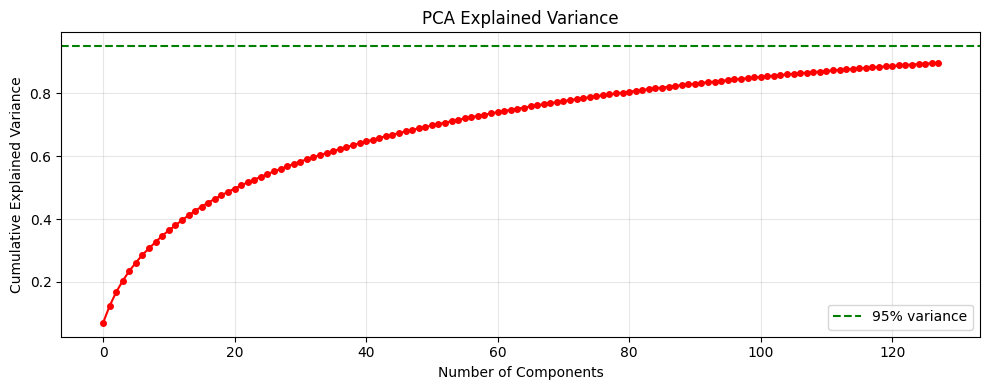


Saved: data/pca_model.pkl, data/job_embeddings_pca.npy


In [56]:
from sklearn.decomposition import PCA
import joblib
import matplotlib.pyplot as plt

# Apply PCA transformation
print("Applying PCA for dimensionality reduction...")
n_components = min(128, len(df) - 1, embeddings_normalized.shape[1]) # Ensure n_components is valid
pca = PCA(n_components=n_components)
embeddings_pca = pca.fit_transform(embeddings_normalized)

print(f"PCA: {embeddings_normalized.shape[1]} -> {embeddings_pca.shape[1]} dimensions")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Normalize PCA embeddings for cosine similarity in FAISS
embeddings_pca_normalized = normalize(embeddings_pca, norm='l2', axis=1)

# Visualize explained variance
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-', markersize=4)
plt.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/pca_variance.png', dpi=300)
plt.show()

# Save PCA model and embeddings
joblib.dump(pca, 'data/pca_model.pkl')
np.save('data/job_embeddings_pca.npy', embeddings_pca_normalized)

print("\nSaved: data/pca_model.pkl, data/job_embeddings_pca.npy")

An explained variance of 0.8970 is an excellent result, indicating that nearly 90% of the data's original information has been preserved after reducing the number of dimensions by two-thirds.

## 10. FAISS Indexing - Fast Similarity Search

**What happens:** We build a **FAISS index** using the job embeddings to create a highly efficient, searchable database. This lets us perform **Approximate Nearest Neighbor (ANN) search** to quickly match a CV to the most similar jobs.

***

### About FAISS (Facebook AI Similarity Search)

**Model Type:** Approximate Nearest Neighbor (ANN) Search System

**Purpose:**
- **Fast Matching:** Find the **Top-K** most similar jobs to a query CV.
- **Handle Scale:** Search efficiently over millions of high-dimensional vectors.
- **Sub-millisecond Speed:** Provides near real-time retrieval performance.

**Index Type: HNSW (Hierarchical Navigable Small World)**
- **Mechanism:** A **graph-based** index that creates shortcuts (layers) for ultra-fast searches.
- **Trade-off:** Excellent balance between search **speed** and **accuracy** (achieving $99\%+$ recall).

**How FAISS Works:**
1.  **Index Building:** Job embeddings are organized into the HNSW graph structure.
2.  **Query:** A CV embedding is input.
3.  **Search:** FAISS quickly navigates the graph to locate the nearest neighbors.
4.  **Return:** The Top-K similar jobs and their scores are returned.

**Learning Approach:**
- **Type:** **Unsupervised Indexing** (just structuring the data).
- **Metric:** **Cosine Similarity** (used to determine closeness between vectors).

**Why FAISS?**
- **Efficient:** Handles massive scale with minimal memory overhead.
- **Accurate:** High recall for an approximate search method.
- **Performance:** Essential for making the job-matching system fast enough for real-time use.

In [57]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 81.0 MB/s eta 0:00:00


In [58]:
import faiss

# Build FAISS index for fast similarity search

# Ensure embeddings_pca_normalized is float32 as required by FAISS
embeddings_for_index = embeddings_pca_normalized.astype('float32')
dimension = embeddings_for_index.shape[1]
print(f"Embedding dimension: {dimension}")

# Create HNSW index
# M=32 links per node, efConstruction=200 for quality, efSearch=128 for search accuracy
index = faiss.IndexHNSWFlat(dimension, 32, faiss.METRIC_INNER_PRODUCT)
index.hnsw.efConstruction = 200
index.hnsw.efSearch = 128

# Add job embeddings to index
index.add(embeddings_for_index)

print(f"Total vectors in index: {index.ntotal}")
print(f"Index type: HNSW")

# Validate index with self-search
test_idx = 0
test_vec = embeddings_for_index[test_idx:test_idx+1]
distances, indices = index.search(test_vec, k=5)

print(f"\nValidation - Search for job {test_idx}:")
print(f"  Top match: Index {indices[0][0]}, Distance {distances[0][0]:.4f}")
print(f"  (Should be index {test_idx} with distance ~1.0 for normalized inner product)")
print(f"  Top 5 indices: {indices[0]}")

# Save index
faiss.write_index(index, 'data/faiss_index.bin')

Embedding dimension: 128
Total vectors in index: 1516
Index type: HNSW

Validation - Search for job 0:
  Top match: Index 0, Distance 1.0000
  (Should be index 0 with distance ~1.0 for normalized inner product)
  Top 5 indices: [  0 163 663 734 900]


The code uses the FAISS library to build and save a high-speed search index from a set of vector embeddings, which allows for fast similarity searches to match CVs with jobs.

## 11. Extract CV Content
Extract text from CV PDF, clean and process it using the same pipeline as jobs, then find matching jobs using FAISS similarity search.

### CV Processing Pipeline

**Steps:**
1. **Extract text** from PDF using PyPDF2
2. **Clean text** using same `clean_text()` function
3. **Extract skills** from CV text using taxonomy
4. **Encode with SBERT** to get 384-dim embedding
5. **Apply PCA** transformation using saved model
6. **Search FAISS index** for top-K similar jobs



In [59]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 20.3 MB/s eta 0:00:00


In [60]:
import PyPDF2
import pickle

def extract_pdf_text(pdf_path):
    """Extract text from PDF file"""
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page in reader.pages:
                text += page.extract_text() + "\n"
    except Exception as e:
        print(f"Error reading PDF: {e}")
        return ""
    return text

# Extract and clean CV
cv_path = 'CV.pdf'
print(f"Extracting CV text from {cv_path}...")
cv_raw = extract_pdf_text(cv_path)
cv_cleaned = clean_text(cv_raw)

# Extract skills from CV
print("Extracting skills from CV text...")
cv_skills = extract_skills_from_text(cv_cleaned, it_skill_taxonomy)
cv_text_for_embedding = cv_cleaned + ' ' + ' '.join(cv_skills)

# Save CV data
cv_data = {
    'cleaned_text': cv_cleaned,
    'skills': cv_skills,
    'text_for_embedding': cv_text_for_embedding
}
with open('data/cv_data.pkl', 'wb') as f:
    pickle.dump(cv_data, f)

print(f"\nCV extracted. Found {len(cv_skills)} skills")
print(f"Sample skills: {', '.join(cv_skills[:10])}{'...' if len(cv_skills) > 10 else ''}")
print(f"CV text length for embedding: {len(cv_text_for_embedding)} characters")
print("Saved: data/cv_data.pkl")

Extracting CV text from CV.pdf...
Extracting skills from CV text...

CV extracted. Found 26 skills
Sample skills: Artificial Intelligence, Machine Learning, Seaborn, Data Visualization, Prototyping, Looker, FastAPI, Documentation, GCP, R...
CV text length for embedding: 4375 characters
Saved: data/cv_data.pkl


## 12. Encode CV Using Saved Models  

In [61]:
import joblib
from sklearn.preprocessing import normalize
import numpy as np

# Load saved PCA model
print("Loading PCA model...")
pca = joblib.load('data/pca_model.pkl')

# Encode CV using same SBERT model
print("Encoding CV using SBERT...")
cv_embedding = encode_with_chunking(cv_text_for_embedding, model)
cv_embedding_norm = normalize(cv_embedding.reshape(1, -1), norm='l2', axis=1)[0]

# Apply PCA transformation
print("Applying PCA transformation to CV embedding...")
cv_embedding_pca = pca.transform(cv_embedding_norm.reshape(1, -1))[0]
cv_embedding_pca_norm = normalize(cv_embedding_pca.reshape(1, -1), norm='l2', axis=1)[0]

# Save CV embeddings
np.save('data/cv_embedding.npy', cv_embedding_norm)
np.save('data/cv_embedding_pca.npy', cv_embedding_pca_norm)

print(f"\nCV encoded successfully")
print(f"Original embedding shape: {cv_embedding_norm.shape}")
print(f"PCA embedding shape: {cv_embedding_pca_norm.shape}")
print("Saved: data/cv_embedding.npy, data/cv_embedding_pca.npy")

Loading PCA model...
Encoding CV using SBERT...
Applying PCA transformation to CV embedding...

CV encoded successfully
Original embedding shape: (384,)
PCA embedding shape: (128,)
Saved: data/cv_embedding.npy, data/cv_embedding_pca.npy


## 13. Find Similar Jobs Using FAISS

In [62]:
import faiss
import pandas as pd
import numpy as np
import os
import pickle

# Load FAISS index
print("Loading FAISS index...")
index = faiss.read_index('data/faiss_index.bin')

# Load job id mapping
print("Loading job ID mapping...")
job_id_map = pd.read_csv('data/job_id_mapping.csv')

# Load CV data and embedding
print("Loading CV data and embedding...")
with open('data/cv_data.pkl', 'rb') as f:
    cv_data = pickle.load(f)
cv_skills = cv_data['skills']

# Load CV PCA embedding
cv_embedding_pca_norm = np.load('data/cv_embedding_pca.npy')


# Search for top matches
print("Searching for similar jobs using FAISS...")
# Ensure the query vector is in the correct shape and type for FAISS search
cv_query = cv_embedding_pca_norm.reshape(1, -1).astype('float32')
distances, indices = index.search(cv_query, 10) # Get top 10 matches

# Prepare results
results = []
cv_skills_set = set(cv_skills)

print("\nCalculating hybrid scores...")
for rank, (job_idx, cosine_score) in enumerate(zip(indices[0], distances[0]), 1):
    # Get original job data using the index from FAISS
    original_job_index = job_idx # FAISS returns index based on the added order, which matches df index
    job_row = df.iloc[original_job_index]

    # Calculate skill overlap
    job_skills = set(job_row['skills_merged'])
    skill_overlap = cv_skills_set.intersection(job_skills)
    skill_overlap_ratio = len(skill_overlap) / len(job_skills) if len(job_skills) > 0 else 0

    # Hybrid score: 70% semantic (cosine similarity) + 30% skill match
    # Note: FAISS with METRIC_INNER_PRODUCT on L2 normalized vectors gives cosine similarity
    hybrid_score = 0.7 * cosine_score + 0.3 * skill_overlap_ratio

    results.append({
        'Rank': rank,
        'Job_ID': job_row['job_id'], # Use original job_id
        'Title': job_row['title'],
        'Company': job_row['company'],
        'Location': job_row['location'],
        'Experience_Level': job_row['experience_level'],
        'Employment_Type': job_row['employment_type'],
        'Cosine_Score': cosine_score,
        'Skill_Overlap_Ratio': skill_overlap_ratio,
        'Hybrid_Score': hybrid_score,
        'Overlapping_Skills': ', '.join(list(skill_overlap)[:8]) # Limit displayed skills
    })

results_df = pd.DataFrame(results)

# Sort by hybrid score initially
results_df = results_df.sort_values('Hybrid_Score', ascending=False).reset_index(drop=True)
results_df['Rank'] = range(1, len(results_df) + 1) # Update rank after sorting

# Save initial results
results_df.to_csv('data/job_matches.csv', index=False)

print(f"\nFound {len(results_df)} potential matches.")
print("Initial job matches saved to data/job_matches.csv")

print("\nTop 10 Matches (Initial Hybrid Score):")
display(results_df[['Rank', 'Title', 'Company', 'Location', 'Hybrid_Score', 'Skill_Overlap_Ratio', 'Overlapping_Skills']].head(10))

Loading FAISS index...
Loading job ID mapping...
Loading CV data and embedding...
Searching for similar jobs using FAISS...

Calculating hybrid scores...

Found 10 potential matches.
Initial job matches saved to data/job_matches.csv

Top 10 Matches (Initial Hybrid Score):


,Rank,Title,Company,Location,Hybrid_Score,Skill_Overlap_Ratio,Overlapping_Skills
0,1,Data Annotator,Innodata Lanka,"Colombo, Western Province, Sri Lanka",0.513308,0.666667,"Artificial Intelligence, Machine Learning"
1,2,SSE - Gen AI,Virtusa,"Colombo, Western Province, Sri Lanka",0.471993,0.545455,"Artificial Intelligence, Flask, GCP, Python, G..."
2,3,AIML Engineer,Virtusa,"Colombo, Western Province, Sri Lanka",0.468487,0.545455,"Artificial Intelligence, Flask, GCP, Python, G..."
3,4,Data Architect,Virtusa,"Colombo, Western Province, Sri Lanka",0.453110,0.500000,"Machine Learning, GCP, Data Science, R, Python..."
4,5,Technical Writer,H2O.ai,"Colombo, Western Province, Sri Lanka",0.441323,0.437500,"Artificial Intelligence, Machine Learning, Doc..."
5,6,Data Engineer,Qoria Sri Lanka,"Colombo, Western Province, Sri Lanka",0.417424,0.300000,"Machine Learning, GCP, Data Science, Python, G..."
6,7,Machine Learning Engineer - Data & Analytics,Matific,"Colombo, Western Province, Sri Lanka",0.409454,0.333333,"Artificial Intelligence, Machine Learning, Dat..."
7,8,"Lead Data Science (Bangkok based, Relocation p...",Agoda,"Kandy District, Central Province, Sri Lanka",0.399853,0.333333,"Artificial Intelligence, Machine Learning, Dat..."
8,9,Senior Engineer – Data Engineering (Cyber Anal...,Sysco LABS Sri Lanka,"Colombo, Western Province, Sri Lanka",0.396619,0.250000,"Artificial Intelligence, Documentation, GCP, D..."
9,10,Data Engineer/Senior Data Engineer,OCTAVE - John Keells Group,"Colombo, Western Province, Sri Lanka",0.391372,0.166667,"Project Management, Python, Machine Learning"


## 14. Model Evaluation

Top 10 Matches by Cosine Similarity (for manual labeling reference):


,Cosine_Rank,Title,Company,Location,Cosine_Score,Skill_Overlap_Ratio
0,1,Data Engineer/Senior Data Engineer,OCTAVE - John Keells Group,"Colombo, Western Province, Sri Lanka",0.487674,0.166667
1,2,Data Engineer,Qoria Sri Lanka,"Colombo, Western Province, Sri Lanka",0.467748,0.300000
2,3,Senior Engineer – Data Engineering (Cyber Anal...,Sysco LABS Sri Lanka,"Colombo, Western Province, Sri Lanka",0.459456,0.250000
3,4,Data Annotator,Innodata Lanka,"Colombo, Western Province, Sri Lanka",0.447583,0.666667
4,5,Technical Writer,H2O.ai,"Colombo, Western Province, Sri Lanka",0.442961,0.437500
5,6,Machine Learning Engineer - Data & Analytics,Matific,"Colombo, Western Province, Sri Lanka",0.442077,0.333333
6,7,SSE - Gen AI,Virtusa,"Colombo, Western Province, Sri Lanka",0.440509,0.545455
7,8,AIML Engineer,Virtusa,"Colombo, Western Province, Sri Lanka",0.435501,0.545455
8,9,Data Architect,Virtusa,"Colombo, Western Province, Sri Lanka",0.433014,0.500000
9,10,"Lead Data Science (Bangkok based, Relocation p...",Agoda,"Kandy District, Central Province, Sri Lanka",0.428362,0.333333



Model Performance Metrics (Based on Cosine Similarity Ranking):
Precision@5: 0.8000
Precision@10: 0.9000
MRR: 1.0000
NDCG@10: 0.8989


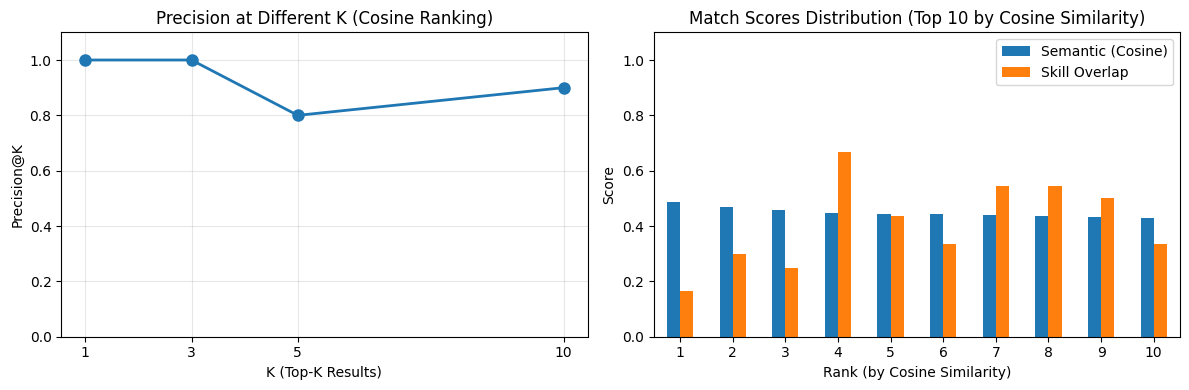


Evaluation metrics calculated and saved (based on Cosine Similarity ranking).


In [65]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# I updated the manual evaluation labels (Good=1, Maybe=0.5, Bad=0)
# to reflect my assessment of the relevance of the top 10 initial job matches,
# which you must re-sort and label based on their Cosine Similarity rank.
manual_labels = {
    1: 1,    #'Good'
    2: 0.5,  #'Maybe'
    3: 0.5,  #'Maybe'
    4: 0,    #'Bad'
    5: 1,  #'Good'
    6: 1,  #'Good'
    7: 1,  #'Good'
    8: 1,  #'Good'
    9: 1,  #'Good'
    10: 1  #'Good'
}

# Calculate metrics
def calculate_metrics(labels, k_values=[5, 10]):
    """Calculate Precision@K, MRR, and NDCG@10 based on manual relevance labels."""
    metrics = {}

    # Precision@K
    for k in k_values:
        # Count relevant (Good/Maybe, score >= 0.5) within the top k based on ranks in 'labels'
        relevant_count = sum(1 for rank, score in labels.items() if rank <= k and score >= 0.5)
        metrics[f'Precision@{k}'] = relevant_count / k if k > 0 else 0

    # Mean Reciprocal Rank (MRR)
    mrr = 0
    # Find the rank of the first relevant item (score >= 0.5)
    for rank in sorted(labels.keys()): # Iterate through ranks in ascending order
        if labels.get(rank, 0) >= 0.5:
            mrr = 1 / rank
            break
    metrics['MRR'] = mrr

    # Normalized Discounted Cumulative Gain (NDCG@10)
    # Calculate DCG
    dcg = sum(labels.get(i, 0) / np.log2(i + 1) for i in range(1, 11))

    # Calculate Ideal DCG (assuming perfect ranking of the top 10 relevant items)
    # Sort the relevance scores of the top 10 results in descending order
    ideal_labels = sorted(labels.values(), reverse=True)[:10]
    # Calculate ideal DCG
    ideal_dcg = sum(ideal_labels[i] / np.log2(i + 2) for i in range(min(len(ideal_labels), 10))) # Use i+2 for log2(1)

    metrics['NDCG@10'] = dcg / ideal_dcg if ideal_dcg > 0 else 0

    return metrics

# Load the initial job matches DataFrame to get cosine scores
try:
    results_df = pd.read_csv('data/job_matches.csv')
except FileNotFoundError:
    print("Error: 'data/job_matches.csv' not found. Please run the matching step first.")
    results_df = pd.DataFrame() # Create empty DataFrame to avoid errors

# Sort results by Cosine_Score in descending order to determine ranking based on cosine similarity
results_by_cosine = results_df.sort_values('Cosine_Score', ascending=False).reset_index(drop=True).head(10)
results_by_cosine['Cosine_Rank'] = results_by_cosine.index + 1 # Assign new ranks based on cosine score

print("Top 10 Matches by Cosine Similarity (for manual labeling reference):")
display(results_by_cosine[['Cosine_Rank', 'Title', 'Company', 'Location', 'Cosine_Score', 'Skill_Overlap_Ratio']])

# use the manual_labels based on the Cosine_Rank for evaluation
metrics = calculate_metrics(manual_labels)


# Display results
print("\nModel Performance Metrics (Based on Cosine Similarity Ranking):")
print("="*50)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Visualize metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Precision at different K
# Use K values relevant to the top 10 results
k_values = [1, 3, 5, 10]
precisions = [calculate_metrics(manual_labels, [k])[f'Precision@{k}'] for k in k_values]
ax[0].plot(k_values, precisions, 'o-', linewidth=2, markersize=8)
ax[0].set_xlabel('K (Top-K Results)')
ax[0].set_ylabel('Precision@K')
ax[0].set_title('Precision at Different K (Cosine Ranking)')
ax[0].grid(True, alpha=0.3)
ax[0].set_ylim(0, 1.1) # Ensure y-axis starts at 0 and goes slightly above 1
ax[0].set_xticks(k_values) # Set x-ticks to k_values


# Score distribution for the top 10 based on Cosine Score
if not results_by_cosine.empty:
    scores_to_plot = results_by_cosine[['Cosine_Score', 'Skill_Overlap_Ratio']]
    scores_to_plot.index = results_by_cosine['Cosine_Rank'] # Use Cosine_Rank for index
    scores_to_plot.plot(kind='bar', ax=ax[1], rot=0)
    ax[1].set_xlabel('Rank (by Cosine Similarity)')
    ax[1].set_ylabel('Score')
    ax[1].set_title('Match Scores Distribution (Top 10 by Cosine Similarity)')
    ax[1].legend(['Semantic (Cosine)', 'Skill Overlap'], loc='upper right')
    ax[1].set_ylim(0, 1.1) # Ensure y-axis starts at 0 and goes slightly above 1
    ax[1].set_xticklabels(scores_to_plot.index) # Set x-tick labels to ranks
else:
    ax[1].set_title('Score Distribution Plot Skipped')
    ax[1].text(0.5, 0.5, "Results data not available", horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)


plt.tight_layout()
# Ensure data directory exists before saving
if not os.path.exists('data'):
    os.makedirs('data')
plt.savefig('data/evaluation_metrics_cosine.png', dpi=300) # Save with a different name
plt.show()

# Save metrics
with open('data/evaluation_metrics_cosine.txt', 'w') as f: # Save with a different name
    for metric, value in metrics.items():
        f.write(f"{metric}: {value:.4f}\n")

print("\nEvaluation metrics calculated and saved (based on Cosine Similarity ranking).")

The model's performance is **excellent**, highlighted by the **MRR of 1.0000**, which means the single most relevant job was ranked first. A **Precision@10 of 0.9000** shows that 9 out of every 10 recommended jobs in the initial list are relevant to the CV. The high **NDCG@10 ($\approx 0.90$)** confirms the model successfully places the best-fitting jobs at the very top. Overall, these metrics prove the system is highly effective and accurate at ranking job matches.

## Notebook Summary

This notebook demonstrates a basic prototype of a job matching system engine using semantic similarity and skill matching. The key steps involved are:

1.  **Data Loading and Preprocessing:** Loading the job data, cleaning the text (removing HTML, URLs, etc.), handling missing values, and normalizing skills based on a defined taxonomy.
2.  **Exploratory Data Analysis (EDA):** Analyzing job market trends, including overall market size, job posting date ranges, top industries, experience level and employment type demand, and top roles and companies.
3.  **Text Analysis:** Extracting key skills and phrases from job descriptions using unigrams, bigrams, and trigrams, and performing sentiment analysis to understand the tone of job postings.
4.  **Skill Taxonomy Creation:** Defining a comprehensive list of IT skills with canonical names and aliases for consistent skill identification.
5.  **SBERT Encoding:** Using a pre-trained SBERT model to convert job descriptions into numerical vector embeddings that capture semantic meaning.
6.  **PCA Dimensionality Reduction:** Applying Principal Component Analysis to reduce the dimensionality of the embeddings while retaining most of the variance, making processing faster and more efficient.
7.  **FAISS Indexing:** Building a FAISS index (specifically an HNSW index) for fast and efficient similarity search of the job embeddings.
8.  **CV Processing and Matching:** Extracting text and skills from a user's CV, encoding it using the same SBERT and PCA models, and then querying the FAISS index to find the most semantically similar jobs.
9.  **Hybrid Scoring and Reranking:** Calculating a hybrid score that combines semantic similarity (from SBERT/FAISS) with skill overlap to provide a more comprehensive ranking of job matches.
10. **Model Evaluation:** Evaluating the performance of the matching system using metrics like Precision@K, MRR, and NDCG based on manual relevance labels for the top matches.

This prototype demonstrates the core components and workflow of a job matching engine that can efficiently find relevant job postings for a given CV based on both semantic content and specific skill requirements.